## Import Libraries

In [1]:
import os
import pandas as pd

import psycopg2

## Connect to the DB

In [2]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'omop_cdm'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

## Static data

In [3]:
staticQuery = """select * from sepsis_micro.static;"""
staticDf = pd.read_sql_query(staticQuery, con)
staticDf

,person_id,gender_source_value,visit_occurrence_concept_name,visit_duration_hrs,visit_source_concept_name,admitting_source_value,age
0,-1792030725,M,Ambulatory Clinic / Center,16.0,AMBULATORY OBSERVATION,None,64.0
1,-1463830843,M,Emergency Room and Inpatient Visit,381.0,URGENT,TRANSFER FROM HOSPITAL,52.0
2,-1309910654,M,Emergency Room and Inpatient Visit,1098.0,URGENT,TRANSFER FROM HOSPITAL,65.0
3,-1132492771,F,Emergency Room and Inpatient Visit,306.0,URGENT,TRANSFER FROM HOSPITAL,48.0
4,299498717,M,Emergency Room and Inpatient Visit,69.0,URGENT,TRANSFER FROM HOSPITAL,57.0
...,...,...,...,...,...,...,...
24267,-629162419,F,Observation Room,72.0,OBSERVATION ADMIT,PHYSICIAN REFERRAL,80.0
24268,-615158116,F,Observation Room,170.0,OBSERVATION ADMIT,EMERGENCY ROOM,83.0
24269,-537876404,M,Observation Room,171.0,OBSERVATION ADMIT,EMERGENCY ROOM,66.0
24270,-407370784,M,Observation Room,137.0,OBSERVATION ADMIT,TRANSFER FROM HOSPITAL,52.0


<AxesSubplot:>

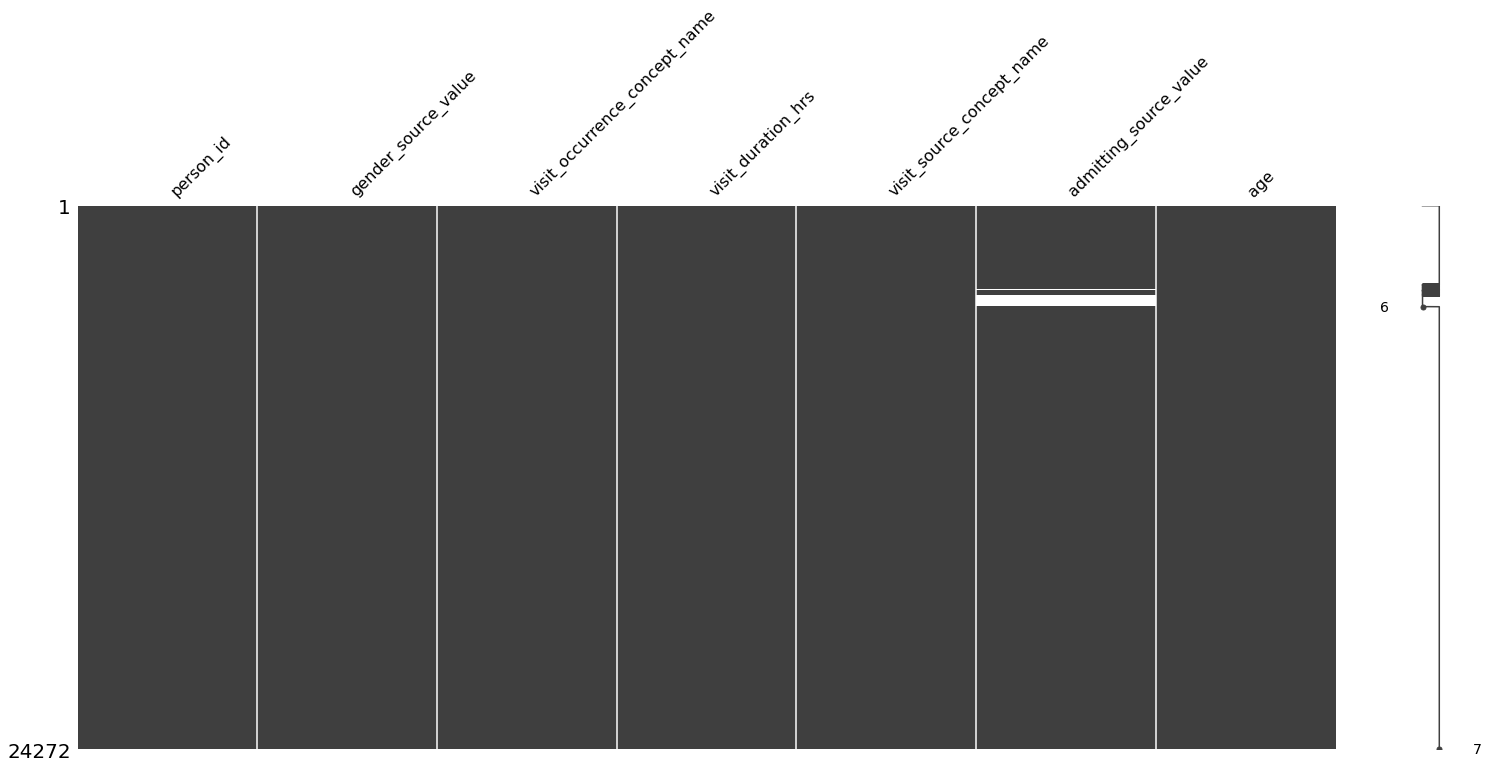

In [4]:
import missingno as msno

msno.matrix(staticDf)

<AxesSubplot:>

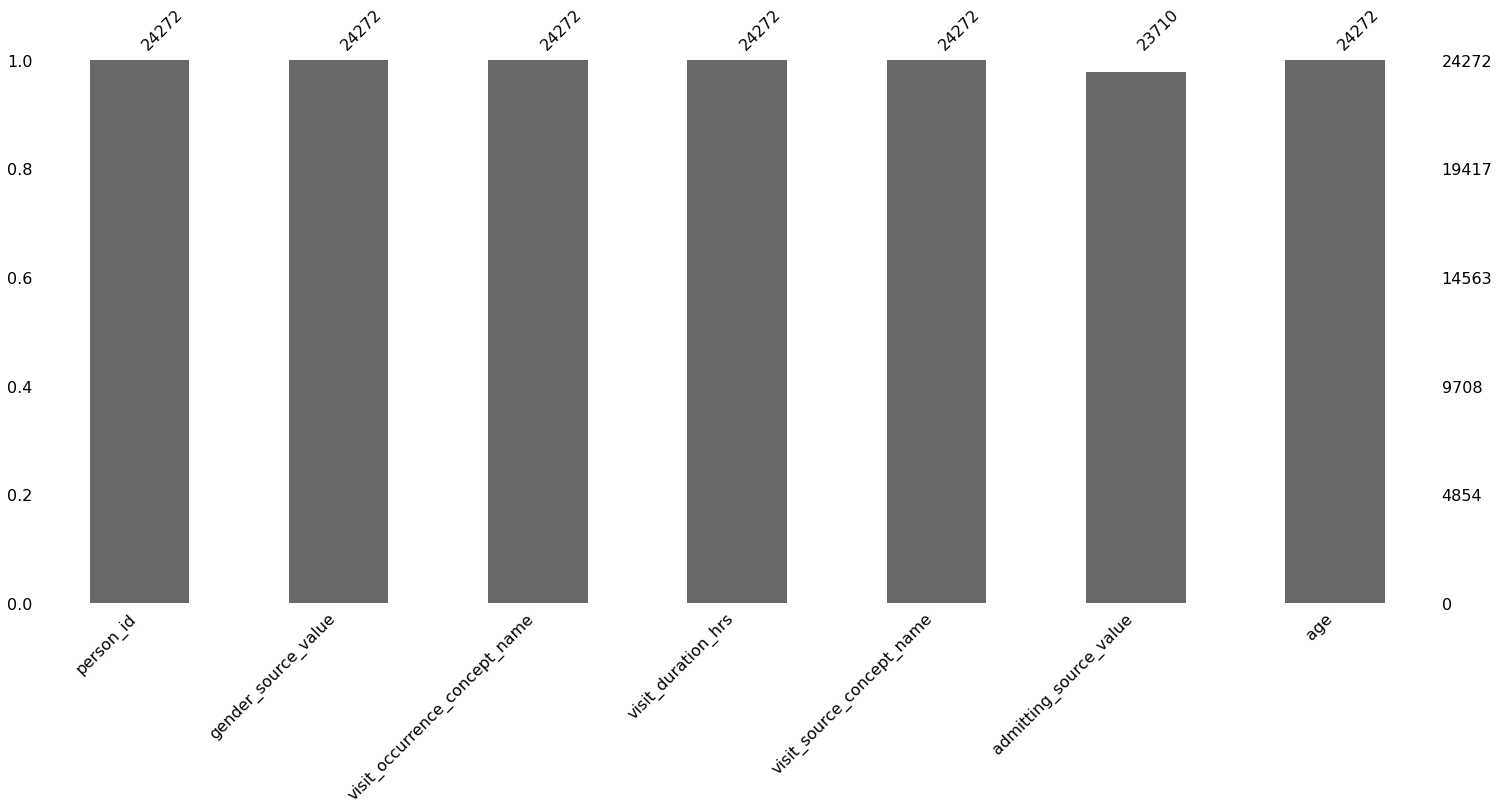

In [5]:
import missingno as msno

msno.bar(staticDf)

In [6]:
staticDf.dropna(inplace=True)
staticDf

,person_id,gender_source_value,visit_occurrence_concept_name,visit_duration_hrs,visit_source_concept_name,admitting_source_value,age
1,-1463830843,M,Emergency Room and Inpatient Visit,381.0,URGENT,TRANSFER FROM HOSPITAL,52.0
2,-1309910654,M,Emergency Room and Inpatient Visit,1098.0,URGENT,TRANSFER FROM HOSPITAL,65.0
3,-1132492771,F,Emergency Room and Inpatient Visit,306.0,URGENT,TRANSFER FROM HOSPITAL,48.0
4,299498717,M,Emergency Room and Inpatient Visit,69.0,URGENT,TRANSFER FROM HOSPITAL,57.0
5,981999673,M,Emergency Room and Inpatient Visit,190.0,URGENT,TRANSFER FROM HOSPITAL,47.0
...,...,...,...,...,...,...,...
24267,-629162419,F,Observation Room,72.0,OBSERVATION ADMIT,PHYSICIAN REFERRAL,80.0
24268,-615158116,F,Observation Room,170.0,OBSERVATION ADMIT,EMERGENCY ROOM,83.0
24269,-537876404,M,Observation Room,171.0,OBSERVATION ADMIT,EMERGENCY ROOM,66.0
24270,-407370784,M,Observation Room,137.0,OBSERVATION ADMIT,TRANSFER FROM HOSPITAL,52.0


## Vitals data

### Read data

In [7]:
vitalsQuery = """select * from sepsis_micro.vitals;"""
vitalsDf = pd.read_sql_query(vitalsQuery, con)
vitalsDf

,person_id,measurement_datetime,unit_source_value,value_as_number,concept_name,rn
0,-2144679073,2194-04-08 23:00:00,°F,94.4,Body temperature,1
1,-2144679073,2194-04-08 23:00:00,°F,94.4,Body temperature,2
2,-2144679073,2194-04-09 01:00:00,°F,97.8,Body temperature,3
3,-2144679073,2194-04-09 01:00:00,°F,97.8,Body temperature,4
4,-2144679073,2194-04-09 04:00:00,°F,97.3,Body temperature,5
...,...,...,...,...,...,...
4205215,2146343948,2161-04-07 08:01:00,mmHg,113.0,Systolic blood pressure by Noninvasive,8
4205216,2146343948,2161-04-07 09:01:00,mmHg,129.0,Systolic blood pressure by Noninvasive,9
4205217,2146343948,2161-04-07 10:01:00,mmHg,105.0,Systolic blood pressure by Noninvasive,10
4205218,2146343948,2161-04-07 12:01:00,mmHg,122.0,Systolic blood pressure by Noninvasive,11


### Missing data

<AxesSubplot:>

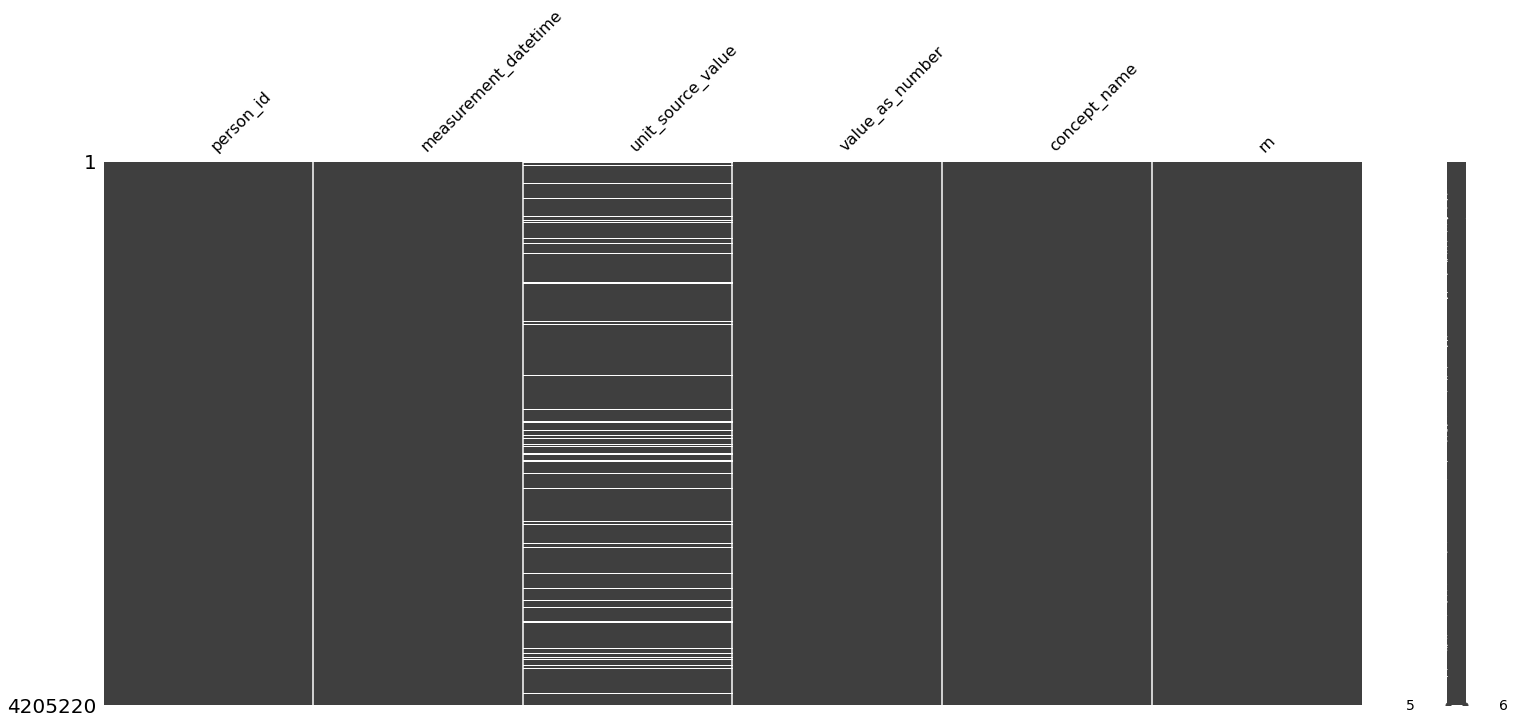

In [8]:
import missingno as msno

msno.matrix(vitalsDf)

<AxesSubplot:>

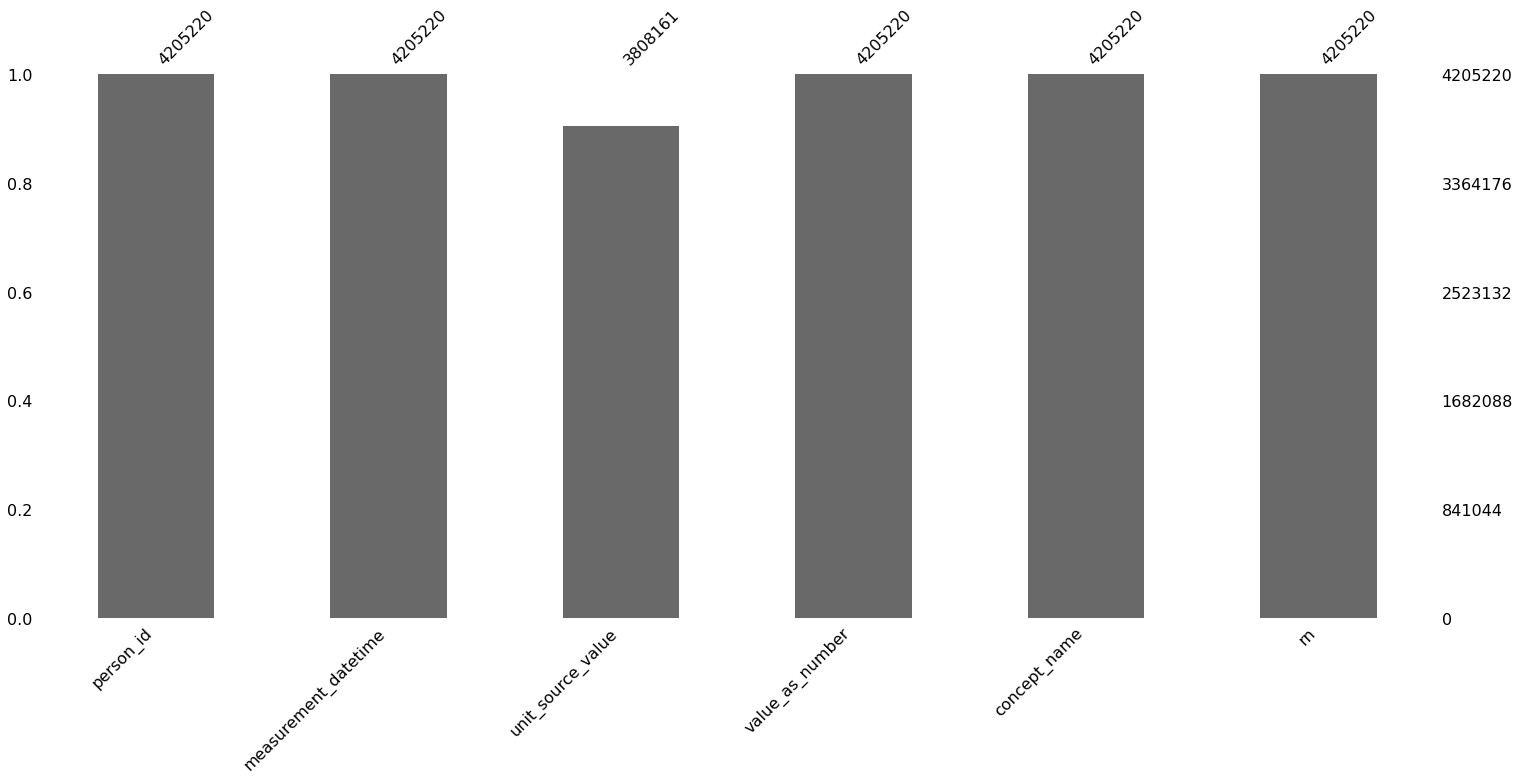

In [9]:
import missingno as msno

msno.bar(vitalsDf)

### Outliers

In [10]:
import numpy as np

def reject_outliers(df):
    data = df[df.value_as_number < vitalsValues.value_as_number.quantile(0.9999)].value_as_number
    inx = df.value_as_number.sub(data.mean()).div(data.std()).abs().le(3)
    return df[inx]

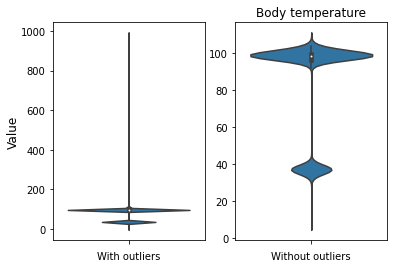

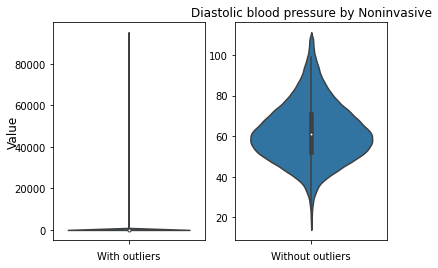

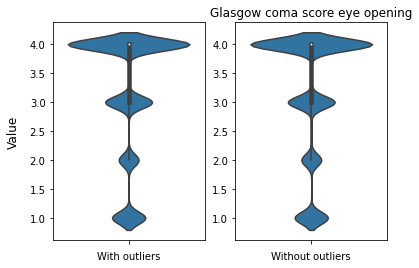

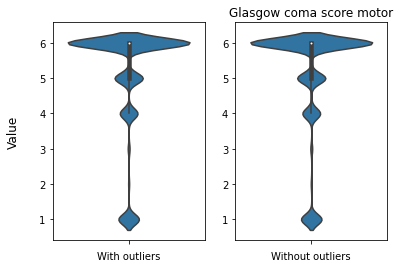

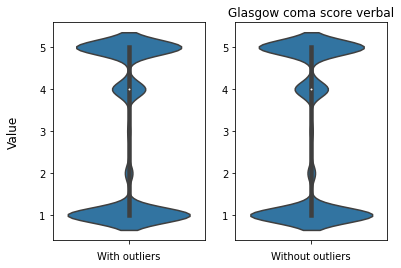

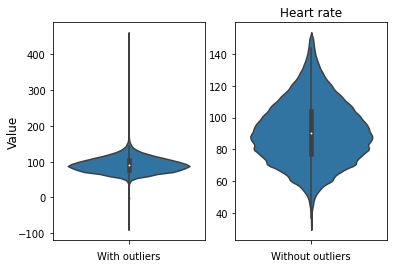

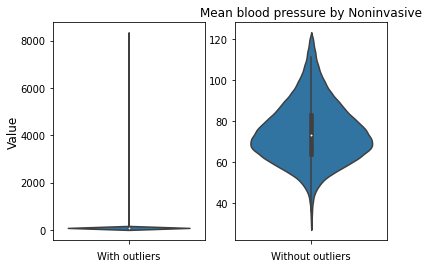

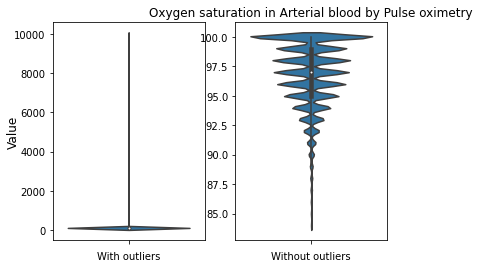

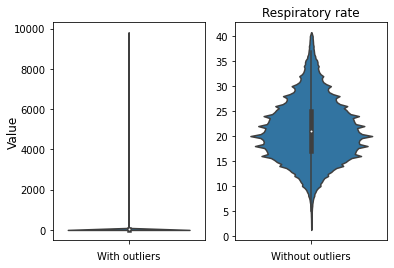

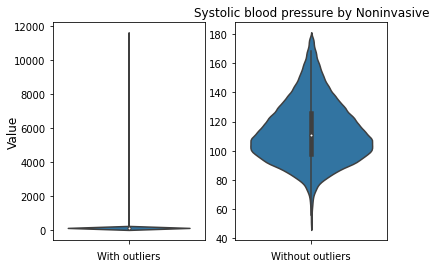

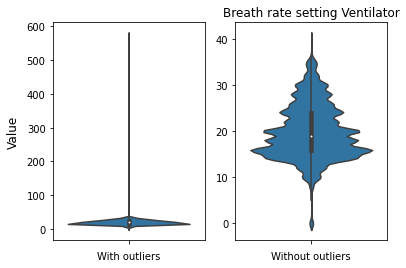

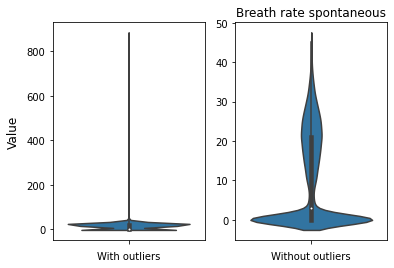

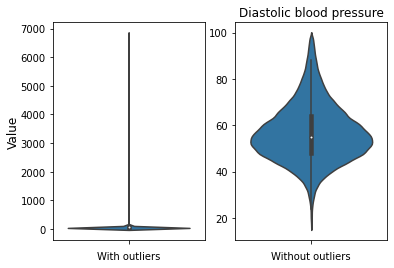

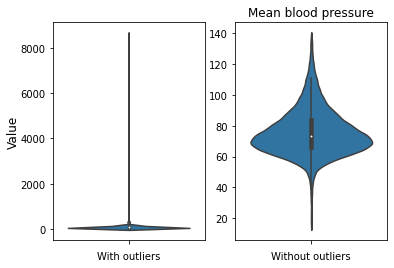

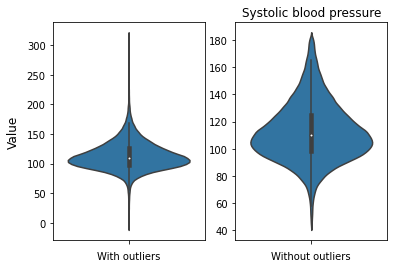

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

vitalsFilteredDf = pd.DataFrame(columns=vitalsDf.columns)

vitalsConcepts = vitalsDf.concept_name.unique()

for v in vitalsConcepts:

    vitalsValues = vitalsDf[vitalsDf.concept_name == v]
    vitalsValuesFiltered = reject_outliers(vitalsValues)

    vitalsFilteredDf = pd.concat([vitalsFilteredDf, vitalsValuesFiltered])

    fig, (ax1, ax2) = plt.subplots(1, 2)

    sns.violinplot(
        y = vitalsValues.value_as_number,
        ax=ax1
    )
    ax1.set_xlabel('With outliers')
    ax1.set_ylabel('')

    sns.violinplot(
        y = vitalsValuesFiltered.value_as_number,
        ax=ax2
    )
    ax2.set_xlabel('Without outliers')
    ax2.set_ylabel('')

    fig.supylabel('Value')
    plt.title(v)
    plt.show()

In [14]:
dropTableQuery = """drop table if exists sepsis_micro.vitals_filtered cascade;"""
createTableQuery = """create table sepsis_micro.vitals_filtered (like sepsis_micro.vitals including all)"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropTableQuery)
        cursor.execute(createTableQuery)

In [24]:
import psycopg2.extras

if len(vitalsFilteredDf) > 0:

    table = 'sepsis_micro.vitals_filtered'

    df_columns = list(vitalsFilteredDf)
    # create (col1,col2,...)
    columns = ",".join(df_columns)

    # create VALUES('%s', '%s",...) one '%s' per column
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 

    #create INSERT INTO table (columns) VALUES('%s',...)
    insert_stmt = "INSERT INTO {} ({}) {}".format(table,columns,values)

    cur = con.cursor()
    psycopg2.extras.execute_batch(cur, insert_stmt, vitalsFilteredDf.values)
    con.commit()
    cur.close()

## Laboratory Measurements

### Read data

In [16]:
labMeasurementsQuery = """select * from sepsis_micro.lab_measurements;"""
labMeasurementsDf = pd.read_sql_query(labMeasurementsQuery, con)
labMeasurementsDf

,person_id,measurement_datetime,unit_source_value,value_as_number,concept_name,rn
0,-2144679073,2194-04-08 22:48:00,mEq/L,13.0,Bicarbonate [Moles/volume] in Serum or Plasma,1
1,-2144679073,2194-04-08 22:48:00,mEq/L,13.0,Bicarbonate [Moles/volume] in Serum or Plasma,2
2,-2144679073,2194-04-09 11:05:00,mEq/L,20.0,Bicarbonate [Moles/volume] in Serum or Plasma,3
3,-2144679073,2194-04-09 11:05:00,mEq/L,20.0,Bicarbonate [Moles/volume] in Serum or Plasma,4
4,-2144679073,2194-04-10 04:13:00,mEq/L,20.0,Bicarbonate [Moles/volume] in Serum or Plasma,5
...,...,...,...,...,...,...
378858,2146653386,2149-03-13 04:31:00,g/dl,13.3,Hemoglobin [Mass/volume] in Blood,2
378859,2146653386,2149-03-13 01:32:00,mEq/L,4.1,Potassium [Moles/volume] in Serum or Plasma,1
378860,2146653386,2149-03-13 04:31:00,mEq/L,3.8,Potassium [Moles/volume] in Serum or Plasma,2
378861,2146653386,2149-03-13 01:32:00,mEq/L,137.0,Sodium [Moles/volume] in Serum or Plasma,1


### Missing data

<AxesSubplot:>

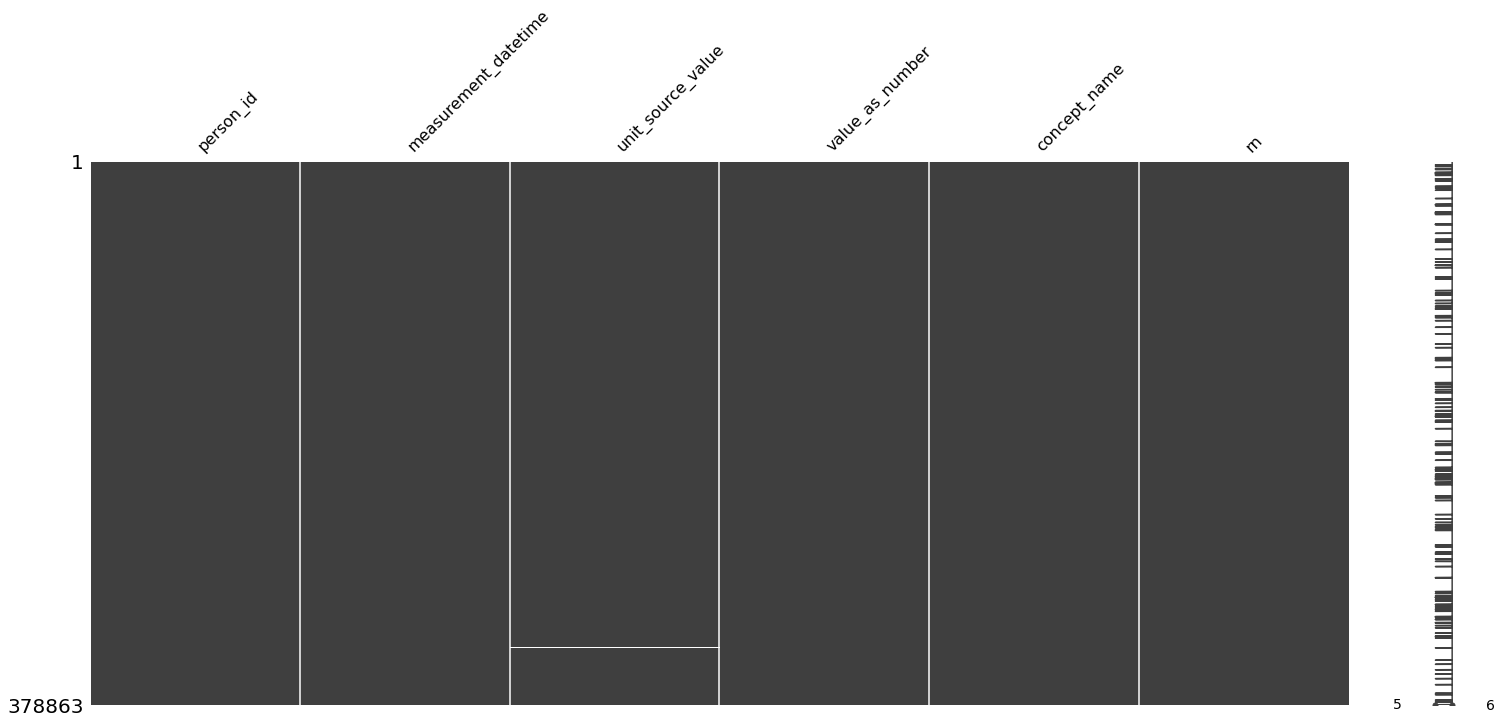

In [17]:
import missingno as msno

msno.matrix(labMeasurementsDf)

<AxesSubplot:>

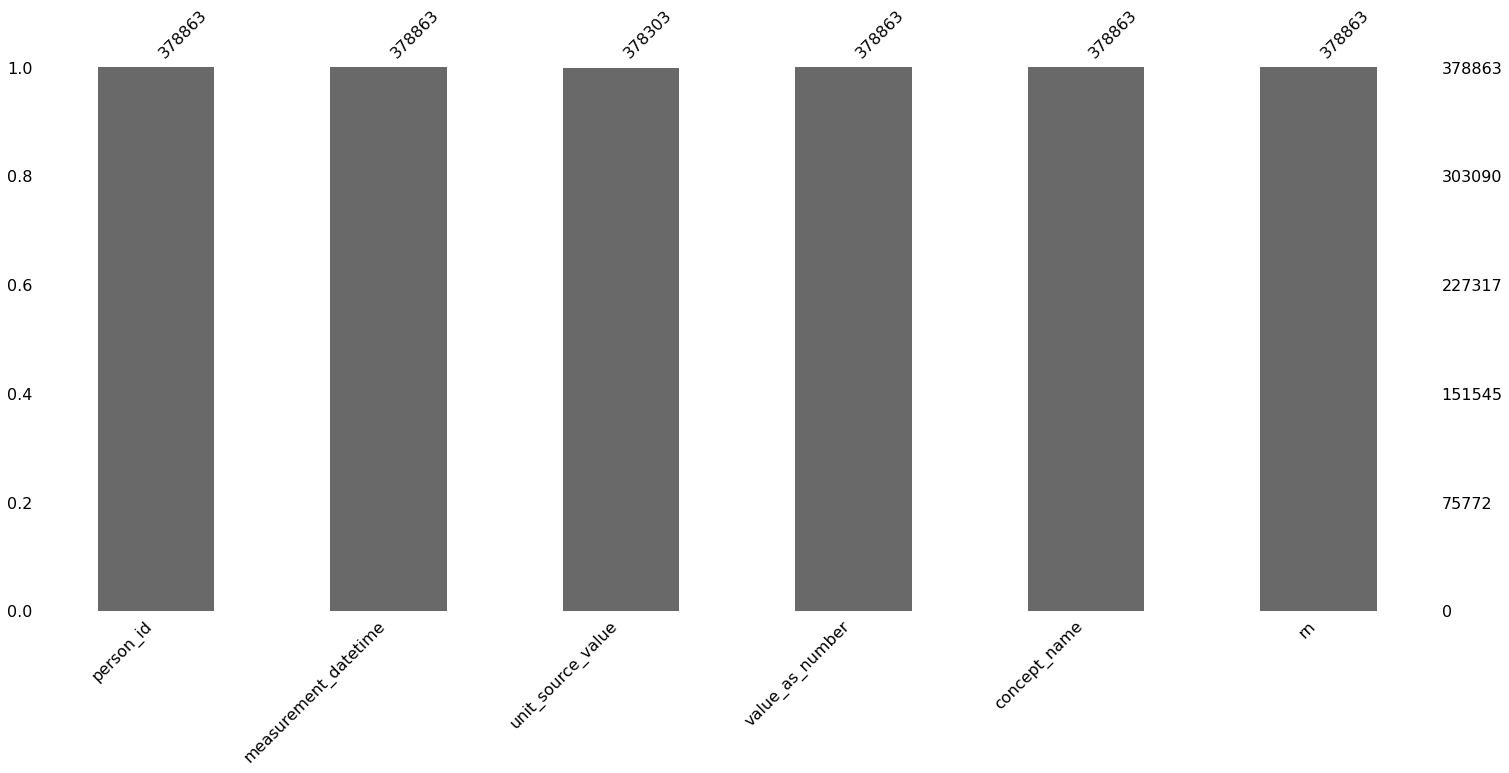

In [18]:
import missingno as msno

msno.bar(labMeasurementsDf)

### Outliers

In [19]:
import numpy as np

def reject_outliers(df):
    data = df[df.value_as_number != 999999].value_as_number
    inx = df.value_as_number.sub(data.mean()).div(data.std()).abs().le(3)
    return df[inx]

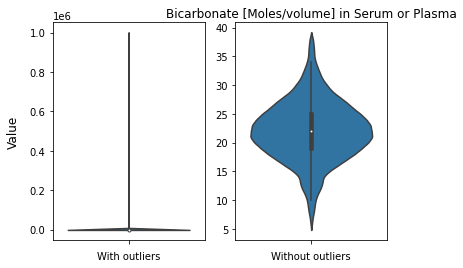

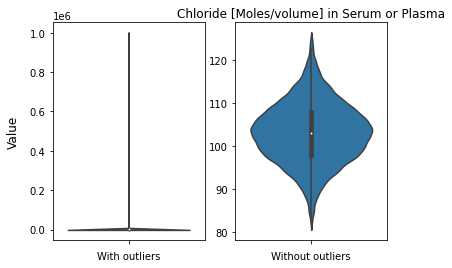

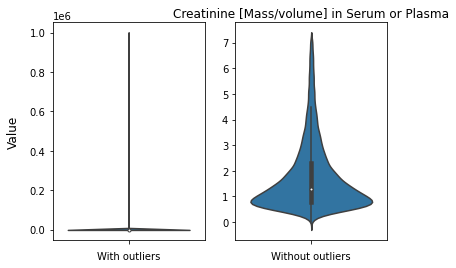

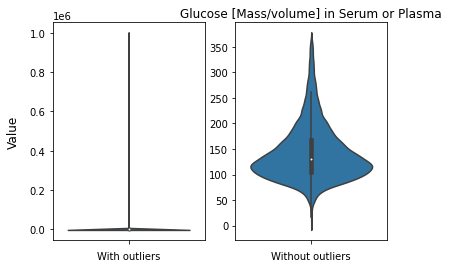

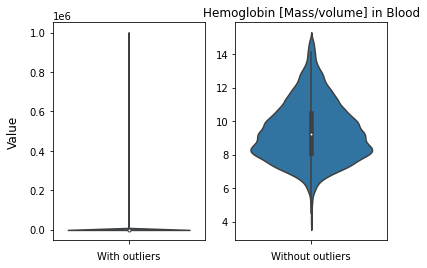

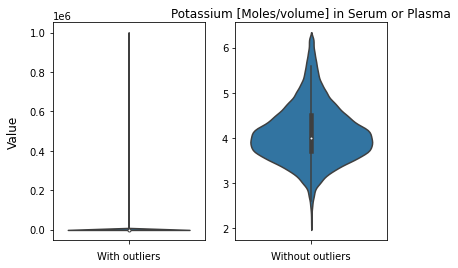

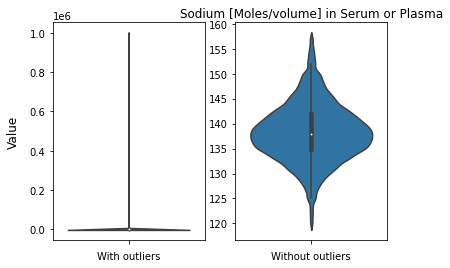

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns

labsFilteredDf = pd.DataFrame(columns=labMeasurementsDf.columns)

labConcepts = labMeasurementsDf.concept_name.unique()

for v in labConcepts:

    labsValues = labMeasurementsDf[labMeasurementsDf.concept_name == v]
    labsValuesFiltered = reject_outliers(labsValues)

    labsFilteredDf = pd.concat([labsFilteredDf, labsValuesFiltered])

    fig, (ax1, ax2) = plt.subplots(1, 2)

    sns.violinplot(
        y = labsValues.value_as_number,
        ax=ax1
    )
    ax1.set_xlabel('With outliers')
    ax1.set_ylabel('')

    sns.violinplot(
        y = labsValuesFiltered.value_as_number,
        ax=ax2
    )
    ax2.set_xlabel('Without outliers')
    ax2.set_ylabel('')

    fig.supylabel('Value')
    plt.title(v)
    plt.show()

In [21]:
dropTableQuery = """drop table if exists sepsis_micro.lab_measurements_filtered cascade;"""
createTableQuery = """create table sepsis_micro.lab_measurements_filtered (like sepsis_micro.lab_measurements including all)"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropTableQuery)
        cursor.execute(createTableQuery)

In [22]:
if len(labsFilteredDf) > 0:

    table = 'sepsis_micro.lab_measurements_filtered'

    df_columns = list(labsFilteredDf)
    # create (col1,col2,...)
    columns = ",".join(df_columns)

    # create VALUES('%s', '%s",...) one '%s' per column
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 

    #create INSERT INTO table (columns) VALUES('%s',...)
    insert_stmt = "INSERT INTO {} ({}) {}".format(table,columns,values)

    cur = con.cursor()
    psycopg2.extras.execute_batch(cur, insert_stmt, labsFilteredDf.values)
    con.commit()
    cur.close()

## Combine data

In [23]:
dropVitalsStg1Query = """drop table if exists sepsis_micro.vitals_stg_1 cascade"""
dataVitals1Query = """
	create table sepsis_micro.vitals_stg_1 as
	select
	vit.person_id as person_id
	, vit.rn as rn
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Body temperature' THEN vit.value_as_number ELSE null END)) AS tmp
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Heart rate' THEN vit.value_as_number ELSE null END)) AS heartrate
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Breath rate setting Ventilator' THEN vit.value_as_number ELSE null END)) AS breath_rate_vent
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Breath rate spontaneous' THEN vit.value_as_number ELSE null END)) AS breath_rate_spon
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Respiratory rate' THEN vit.value_as_number ELSE null END)) AS resp_rate
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Oxygen saturation in Arterial blood by Pulse oximetry' THEN vit.value_as_number ELSE null END)) AS oxygen
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Systolic blood pressure' THEN vit.value_as_number ELSE null END)) AS sysbp
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Diastolic blood pressure' THEN vit.value_as_number ELSE null END)) AS diabp
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Mean blood pressure' THEN vit.value_as_number ELSE null END)) AS meanbp
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Systolic blood pressure by Noninvasive' THEN vit.value_as_number ELSE null END)) AS sysbp_ni
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Diastolic blood pressure by Noninvasive' THEN vit.value_as_number ELSE null END)) AS diabp_ni
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Mean blood pressure by Noninvasive' THEN vit.value_as_number ELSE null END)) AS meanbp_ni
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Glasgow coma score motor' THEN vit.value_as_number ELSE null END)) AS gcs_motor
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Glasgow coma score verbal' THEN vit.value_as_number ELSE null END)) AS gcs_verbal
	, COALESCE(MAX(CASE WHEN vit.concept_name = 'Glasgow coma score eye opening' THEN vit.value_as_number ELSE null END)) AS gcs_eye
	from
	sepsis_micro.vitals_filtered vit
	group by vit.person_id, vit.rn
	;
	"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropVitalsStg1Query)
        cursor.execute(dataVitals1Query)

In [25]:
dropVitalsMaxQuery = """drop table if exists sepsis_micro.vitals_max cascade"""
dataVitalsMaxQuery = """
	create table sepsis_micro.vitals_max as
    select
    distinct
    vit.person_id as person_id
    , max(vit.tmp) over (partition by vit.person_id) as temp_max
    , max(vit.heartrate) over (partition by vit.person_id) as heartrate_max
    , max(vit.breath_rate_vent) over (partition by vit.person_id) as breath_rate_vent_max
    , max(vit.breath_rate_spon) over (partition by vit.person_id) as breath_rate_spon_max
    , max(vit.resp_rate) over (partition by vit.person_id) as resp_rate_max
    , max(vit.oxygen) over (partition by vit.person_id) as oxygen_max
    , max(vit.sysbp) over (partition by vit.person_id) as sysbp_max
    , max(vit.diabp) over (partition by vit.person_id) as diabp_max
    , max(vit.meanbp) over (partition by vit.person_id) as meanbp_max
    , max(vit.sysbp_ni) over (partition by vit.person_id) as sysbp_ni_max
    , max(vit.diabp_ni) over (partition by vit.person_id) as diabp_ni_max
    , max(vit.meanbp_ni) over (partition by vit.person_id) as meanbp_ni_max
    , max(vit.gcs_motor) over (partition by vit.person_id) as gcs_motor_max
    , max(vit.gcs_verbal) over (partition by vit.person_id) as gcs_verbal_max
    , max(vit.gcs_eye) over (partition by vit.person_id) as gcs_eye_max
    from sepsis_micro.vitals_stg_1 vit
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropVitalsMaxQuery)
        cursor.execute(dataVitalsMaxQuery)

In [26]:
dropVitalsMinQuery = """drop table if exists sepsis_micro.vitals_min cascade"""
dataVitalsMinQuery = """
	create table sepsis_micro.vitals_min as
    select
    distinct
    vit.person_id as person_id
    , min(vit.tmp) over (partition by vit.person_id) as temp_min
    , min(vit.heartrate) over (partition by vit.person_id) as heartrate_min
    , min(vit.breath_rate_vent) over (partition by vit.person_id) as breath_rate_vent_min
    , min(vit.breath_rate_spon) over (partition by vit.person_id) as breath_rate_spon_min
    , min(vit.resp_rate) over (partition by vit.person_id) as resp_rate_min
    , min(vit.oxygen) over (partition by vit.person_id) as oxygen_min
    , min(vit.sysbp) over (partition by vit.person_id) as sysbp_min
    , min(vit.diabp) over (partition by vit.person_id) as diabp_min
    , min(vit.meanbp) over (partition by vit.person_id) as meanbp_min
    , min(vit.sysbp_ni) over (partition by vit.person_id) as sysbp_ni_min
    , min(vit.diabp_ni) over (partition by vit.person_id) as diabp_ni_min
    , min(vit.meanbp_ni) over (partition by vit.person_id) as meanbp_ni_min
    , min(vit.gcs_motor) over (partition by vit.person_id) as gcs_motor_min
    , min(vit.gcs_verbal) over (partition by vit.person_id) as gcs_verbal_min
    , min(vit.gcs_eye) over (partition by vit.person_id) as gcs_eye_min
    from sepsis_micro.vitals_stg_1 vit
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropVitalsMinQuery)
        cursor.execute(dataVitalsMinQuery)

In [27]:
dropVitalsAvgQuery = """drop table if exists sepsis_micro.vitals_avg cascade"""
dataVitalsAvgQuery = """
	create table sepsis_micro.vitals_avg as
    select
    distinct
    vit.person_id as person_id
    , avg(vit.tmp) over (partition by vit.person_id) as temp_avg
    , avg(vit.heartrate) over (partition by vit.person_id) as heartrate_avg
    , avg(vit.breath_rate_vent) over (partition by vit.person_id) as breath_rate_vent_avg
    , avg(vit.breath_rate_spon) over (partition by vit.person_id) as breath_rate_spon_avg
    , avg(vit.resp_rate) over (partition by vit.person_id) as resp_rate_avg
    , avg(vit.oxygen) over (partition by vit.person_id) as oxygen_avg
    , avg(vit.sysbp) over (partition by vit.person_id) as sysbp_avg
    , avg(vit.diabp) over (partition by vit.person_id) as diabp_avg
    , avg(vit.meanbp) over (partition by vit.person_id) as meanbp_avg
    , avg(vit.sysbp_ni) over (partition by vit.person_id) as sysbp_ni_avg
    , avg(vit.diabp_ni) over (partition by vit.person_id) as diabp_ni_avg
    , avg(vit.meanbp_ni) over (partition by vit.person_id) as meanbp_ni_avg
    , avg(vit.gcs_motor) over (partition by vit.person_id) as gcs_motor_avg
    , avg(vit.gcs_verbal) over (partition by vit.person_id) as gcs_verbal_avg
    , avg(vit.gcs_eye) over (partition by vit.person_id) as gcs_eye_avg
    from sepsis_micro.vitals_stg_1 vit
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropVitalsAvgQuery)
        cursor.execute(dataVitalsAvgQuery)

In [28]:
dropVitalsStddevQuery = """drop table if exists sepsis_micro.vitals_stddev cascade"""
dataVitalsStddevQuery = """
	create table sepsis_micro.vitals_stddev as
    select
    distinct
    vit.person_id as person_id
    , stddev(vit.tmp) over (partition by vit.person_id) as temp_sd
    , stddev(vit.heartrate) over (partition by vit.person_id) as heartrate_sd
    , stddev(vit.breath_rate_vent) over (partition by vit.person_id) as breath_rate_vent_sd
    , stddev(vit.breath_rate_spon) over (partition by vit.person_id) as breath_rate_spon_sd
    , stddev(vit.resp_rate) over (partition by vit.person_id) as resp_rate_sd
    , stddev(vit.oxygen) over (partition by vit.person_id) as oxygen_sd
    , stddev(vit.sysbp) over (partition by vit.person_id) as sysbp_sd
    , stddev(vit.diabp) over (partition by vit.person_id) as diabp_sd
    , stddev(vit.meanbp) over (partition by vit.person_id) as meanbp_sd
    , stddev(vit.sysbp_ni) over (partition by vit.person_id) as sysbp_ni_sd
    , stddev(vit.diabp_ni) over (partition by vit.person_id) as diabp_ni_sd
    , stddev(vit.meanbp_ni) over (partition by vit.person_id) as meanbp_ni_sd
    , stddev(vit.gcs_motor) over (partition by vit.person_id) as gcs_motor_sd
    , stddev(vit.gcs_verbal) over (partition by vit.person_id) as gcs_verbal_sd
    , stddev(vit.gcs_eye) over (partition by vit.person_id) as gcs_eye_sd
    from sepsis_micro.vitals_stg_1 vit
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropVitalsStddevQuery)
        cursor.execute(dataVitalsStddevQuery)

In [29]:
dropVitalsFirstQuery = """drop table if exists sepsis_micro.vitals_first cascade"""
dataVitalsFirstQuery = """
	create table sepsis_micro.vitals_first as
    select
    distinct
    vit.person_id as person_id
    , first_value(vit.tmp) over (partition by vit.person_id order by case when vit.tmp is not null then 0 else 1 end asc, vit.rn asc) as temp_first
    , first_value(vit.heartrate) over (partition by vit.person_id order by case when vit.heartrate is not null then 0 else 1 end asc, vit.rn asc) as heartrate_first
    , first_value(vit.breath_rate_vent) over (partition by vit.person_id order by case when vit.breath_rate_vent is not null then 0 else 1 end asc, vit.rn asc) as breath_rate_vent_first
    , first_value(vit.breath_rate_spon) over (partition by vit.person_id order by case when vit.breath_rate_spon is not null then 0 else 1 end asc, vit.rn asc) as breath_rate_spon_first
    , first_value(vit.resp_rate) over (partition by vit.person_id order by case when vit.resp_rate is not null then 0 else 1 end asc, vit.rn asc) as resp_rate_first
    , first_value(vit.oxygen) over (partition by vit.person_id order by case when vit.oxygen is not null then 0 else 1 end asc, vit.rn asc) as oxygen_first
    , first_value(vit.sysbp) over (partition by vit.person_id order by case when vit.sysbp is not null then 0 else 1 end asc, vit.rn asc) as sysbp_first
    , first_value(vit.diabp) over (partition by vit.person_id order by case when vit.diabp is not null then 0 else 1 end asc, vit.rn asc) as diabp_first
    , first_value(vit.meanbp) over (partition by vit.person_id order by case when vit.meanbp is not null then 0 else 1 end asc, vit.rn asc) as meanbp_first
    , first_value(vit.sysbp_ni) over (partition by vit.person_id order by case when vit.sysbp_ni is not null then 0 else 1 end asc, vit.rn asc) as sysbp_ni_first
    , first_value(vit.diabp_ni) over (partition by vit.person_id order by case when vit.diabp_ni is not null then 0 else 1 end asc, vit.rn asc) as diabp_ni_first
    , first_value(vit.meanbp_ni) over (partition by vit.person_id order by case when vit.meanbp_ni is not null then 0 else 1 end asc, vit.rn asc) as meanbp_ni_first
    , first_value(vit.gcs_motor) over (partition by vit.person_id order by case when vit.gcs_motor is not null then 0 else 1 end asc, vit.rn asc) as gcs_motor_first
    , first_value(vit.gcs_verbal) over (partition by vit.person_id order by case when vit.gcs_verbal is not null then 0 else 1 end asc, vit.rn asc) as gcs_verbal_first
    , first_value(vit.gcs_eye) over (partition by vit.person_id order by case when vit.gcs_eye is not null then 0 else 1 end asc, vit.rn asc) as gcs_eye_first
    from sepsis_micro.vitals_stg_1 vit
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropVitalsFirstQuery)
        cursor.execute(dataVitalsFirstQuery)

In [30]:
dropVitalsLastQuery = """drop table if exists sepsis_micro.vitals_last cascade"""
dataVitalsLastQuery = """
	create table sepsis_micro.vitals_last as
    select
    distinct
    vit.person_id as person_id
    , first_value(vit.tmp) over (partition by vit.person_id order by case when vit.tmp is not null then 0 else 1 end asc, vit.rn desc) as temp_last
    , first_value(vit.heartrate) over (partition by vit.person_id order by case when vit.heartrate is not null then 0 else 1 end asc, vit.rn desc) as heartrate_last
    , first_value(vit.breath_rate_vent) over (partition by vit.person_id order by case when vit.breath_rate_vent is not null then 0 else 1 end asc, vit.rn desc) as breath_rate_vent_last
    , first_value(vit.breath_rate_spon) over (partition by vit.person_id order by case when vit.breath_rate_spon is not null then 0 else 1 end asc, vit.rn desc) as breath_rate_spon_last
    , first_value(vit.resp_rate) over (partition by vit.person_id order by case when vit.resp_rate is not null then 0 else 1 end asc, vit.rn desc) as resp_rate_last
    , first_value(vit.oxygen) over (partition by vit.person_id order by case when vit.oxygen is not null then 0 else 1 end asc, vit.rn desc) as oxygen_last
    , first_value(vit.sysbp) over (partition by vit.person_id order by case when vit.sysbp is not null then 0 else 1 end asc, vit.rn desc) as sysbp_last
    , first_value(vit.diabp) over (partition by vit.person_id order by case when vit.diabp is not null then 0 else 1 end asc, vit.rn desc) as diabp_last
    , first_value(vit.meanbp) over (partition by vit.person_id order by case when vit.meanbp is not null then 0 else 1 end asc, vit.rn desc) as meanbp_last
    , first_value(vit.sysbp_ni) over (partition by vit.person_id order by case when vit.sysbp_ni is not null then 0 else 1 end asc, vit.rn desc) as sysbp_ni_last
    , first_value(vit.diabp_ni) over (partition by vit.person_id order by case when vit.diabp_ni is not null then 0 else 1 end asc, vit.rn desc) as diabp_ni_last
    , first_value(vit.meanbp_ni) over (partition by vit.person_id order by case when vit.meanbp_ni is not null then 0 else 1 end asc, vit.rn desc) as meanbp_ni_last
    , first_value(vit.gcs_motor) over (partition by vit.person_id order by case when vit.gcs_motor is not null then 0 else 1 end asc, vit.rn desc) as gcs_motor_last
    , first_value(vit.gcs_verbal) over (partition by vit.person_id order by case when vit.gcs_verbal is not null then 0 else 1 end asc, vit.rn desc) as gcs_verbal_last
    , first_value(vit.gcs_eye) over (partition by vit.person_id order by case when vit.gcs_eye is not null then 0 else 1 end asc, vit.rn desc) as gcs_eye_last
    from sepsis_micro.vitals_stg_1 vit
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropVitalsLastQuery)
        cursor.execute(dataVitalsLastQuery)

In [34]:
dropLabsStg1Query = """drop table if exists sepsis_micro.lab_measurements_stg_1 cascade"""
dataLabs1Query = """
	create table sepsis_micro.lab_measurements_stg_1 as
	select
	lab.person_id as person_id
	, lab.rn as rn
	, COALESCE(MAX(CASE WHEN lab.concept_name = 'Potassium [Moles/volume] in Serum or Plasma' THEN lab.value_as_number ELSE null END)) AS potassium
	, COALESCE(MAX(CASE WHEN lab.concept_name = 'Chloride [Moles/volume] in Serum or Plasma' THEN lab.value_as_number ELSE null END)) AS chloride
	, COALESCE(MAX(CASE WHEN lab.concept_name = 'Glucose [Mass/volume] in Serum or Plasma' THEN lab.value_as_number ELSE null END)) AS glucose
	, COALESCE(MAX(CASE WHEN lab.concept_name = 'Sodium [Moles/volume] in Serum or Plasma' THEN lab.value_as_number ELSE null END)) AS sodium
	, COALESCE(MAX(CASE WHEN lab.concept_name = 'Bicarbonate [Moles/volume] in Serum or Plasma' THEN lab.value_as_number ELSE null END)) AS bicarbonate
	, COALESCE(MAX(CASE WHEN lab.concept_name = 'Hemoglobin [Mass/volume] in Blood' THEN lab.value_as_number ELSE null END)) AS hemoglobin
	, COALESCE(MAX(CASE WHEN lab.concept_name = 'Creatinine [Mass/volume] in Serum or Plasma' THEN lab.value_as_number ELSE null END)) AS creatinine
	from
	sepsis_micro.lab_measurements_filtered lab
	group by lab.person_id, lab.rn
	;
	"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropLabsStg1Query)
        cursor.execute(dataLabs1Query)


In [37]:
dropLabsMaxQuery = """drop table if exists sepsis_micro.lab_measurements_max cascade"""
dataLabsMaxQuery = """
	create table sepsis_micro.lab_measurements_max as
    select
    distinct
    lab.person_id as person_id
    , max(lab.potassium) over (partition by lab.person_id) as potassium_max
    , max(lab.chloride) over (partition by lab.person_id) as chloride_max
    , max(lab.glucose) over (partition by lab.person_id) as glucose_max
    , max(lab.sodium) over (partition by lab.person_id) as sodium_max
    , max(lab.bicarbonate) over (partition by lab.person_id) as bicarbonate_max
    , max(lab.hemoglobin) over (partition by lab.person_id) as hemoglobin_max
    , max(lab.creatinine) over (partition by lab.person_id) as creatinine_max
    from sepsis_micro.lab_measurements_stg_1 lab
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropLabsMaxQuery)
        cursor.execute(dataLabsMaxQuery)

In [38]:
dropLabsMinQuery = """drop table if exists sepsis_micro.lab_measurements_min cascade"""
dataLabsMinQuery = """
	create table sepsis_micro.lab_measurements_min as
    select
    distinct
    lab.person_id as person_id
    , min(lab.potassium) over (partition by lab.person_id) as potassium_min
    , min(lab.chloride) over (partition by lab.person_id) as chloride_min
    , min(lab.glucose) over (partition by lab.person_id) as glucose_min
    , min(lab.sodium) over (partition by lab.person_id) as sodium_min
    , min(lab.bicarbonate) over (partition by lab.person_id) as bicarbonate_min
    , min(lab.hemoglobin) over (partition by lab.person_id) as hemoglobin_min
    , min(lab.creatinine) over (partition by lab.person_id) as creatinine_min
    from sepsis_micro.lab_measurements_stg_1 lab
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropLabsMinQuery)
        cursor.execute(dataLabsMinQuery)

In [40]:
dropLabsAvgQuery = """drop table if exists sepsis_micro.lab_measurements_avg cascade"""
dataLabsAvgQuery = """
	create table sepsis_micro.lab_measurements_avg as
    select
    distinct
    lab.person_id as person_id
    , avg(lab.potassium) over (partition by lab.person_id) as potassium_avg
    , avg(lab.chloride) over (partition by lab.person_id) as chloride_avg
    , avg(lab.glucose) over (partition by lab.person_id) as glucose_avg
    , avg(lab.sodium) over (partition by lab.person_id) as sodium_avg
    , avg(lab.bicarbonate) over (partition by lab.person_id) as bicarbonate_avg
    , avg(lab.hemoglobin) over (partition by lab.person_id) as hemoglobin_avg
    , avg(lab.creatinine) over (partition by lab.person_id) as creatinine_avg
    from sepsis_micro.lab_measurements_stg_1 lab
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropLabsAvgQuery)
        cursor.execute(dataLabsAvgQuery)

In [41]:
dropLabsSdQuery = """drop table if exists sepsis_micro.lab_measurements_stddev cascade"""
dataLabsSdQuery = """
	create table sepsis_micro.lab_measurements_stddev as
    select
    distinct
    lab.person_id as person_id
    , stddev(lab.potassium) over (partition by lab.person_id) as potassium_sd
    , stddev(lab.chloride) over (partition by lab.person_id) as chloride_sd
    , stddev(lab.glucose) over (partition by lab.person_id) as glucose_sd
    , stddev(lab.sodium) over (partition by lab.person_id) as sodium_sd
    , stddev(lab.bicarbonate) over (partition by lab.person_id) as bicarbonate_sd
    , stddev(lab.hemoglobin) over (partition by lab.person_id) as hemoglobin_sd
    , stddev(lab.creatinine) over (partition by lab.person_id) as creatinine_sd
    from sepsis_micro.lab_measurements_stg_1 lab
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropLabsSdQuery)
        cursor.execute(dataLabsSdQuery)

In [42]:
dropLabsFirstQuery = """drop table if exists sepsis_micro.lab_measurements_first cascade"""
dataLabsFirstQuery = """
	create table sepsis_micro.lab_measurements_first as
    select
    distinct
    lab.person_id as person_id
    , first_value(lab.potassium) over (partition by lab.person_id order by case when lab.potassium is not null then 0 else 1 end asc, lab.rn asc) as potassium_first
    , first_value(lab.chloride) over (partition by lab.person_id order by case when lab.chloride is not null then 0 else 1 end asc, lab.rn asc) as chloride_first
    , first_value(lab.glucose) over (partition by lab.person_id order by case when lab.glucose is not null then 0 else 1 end asc, lab.rn asc) as glucose_first
    , first_value(lab.sodium) over (partition by lab.person_id order by case when lab.sodium is not null then 0 else 1 end asc, lab.rn asc) as sodium_first
    , first_value(lab.bicarbonate) over (partition by lab.person_id order by case when lab.bicarbonate is not null then 0 else 1 end asc, lab.rn asc) as bicarbonate_first
    , first_value(lab.hemoglobin) over (partition by lab.person_id order by case when lab.hemoglobin is not null then 0 else 1 end asc, lab.rn asc) as hemoglobin_first
    , first_value(lab.creatinine) over (partition by lab.person_id order by case when lab.creatinine is not null then 0 else 1 end asc, lab.rn asc) as creatinine_first
    from sepsis_micro.lab_measurements_stg_1 lab
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropLabsFirstQuery)
        cursor.execute(dataLabsFirstQuery)

In [43]:
dropLabsLastQuery = """drop table if exists sepsis_micro.lab_measurements_last cascade"""
dataLabsLastQuery = """
	create table sepsis_micro.lab_measurements_last as
    select
    distinct
    lab.person_id as person_id
    , first_value(lab.potassium) over (partition by lab.person_id order by case when lab.potassium is not null then 0 else 1 end asc, lab.rn desc) as potassium_last
    , first_value(lab.chloride) over (partition by lab.person_id order by case when lab.chloride is not null then 0 else 1 end asc, lab.rn desc) as chloride_last
    , first_value(lab.glucose) over (partition by lab.person_id order by case when lab.glucose is not null then 0 else 1 end asc, lab.rn desc) as glucose_last
    , first_value(lab.sodium) over (partition by lab.person_id order by case when lab.sodium is not null then 0 else 1 end asc, lab.rn desc) as sodium_last
    , first_value(lab.bicarbonate) over (partition by lab.person_id order by case when lab.bicarbonate is not null then 0 else 1 end asc, lab.rn desc) as bicarbonate_last
    , first_value(lab.hemoglobin) over (partition by lab.person_id order by case when lab.hemoglobin is not null then 0 else 1 end asc, lab.rn desc) as hemoglobin_last
    , first_value(lab.creatinine) over (partition by lab.person_id order by case when lab.creatinine is not null then 0 else 1 end asc, lab.rn desc) as creatinine_last
    from sepsis_micro.lab_measurements_stg_1 lab
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropLabsLastQuery)
        cursor.execute(dataLabsLastQuery)

In [47]:
dropDataMatrixQuery = """drop table if exists sepsis_micro.data_matrix cascade"""
dataDataMatrixQuery = """
	create table sepsis_micro.data_matrix as
    select
    sta."person_id"
    , sta."visit_occurrence_concept_name"
    , sta."visit_duration_hrs"
    , sta."visit_source_concept_name"
    , sta."admitting_source_value"
    , vit_max."temp_max"
    , vit_max."heartrate_max"
    , vit_max."breath_rate_vent_max"
    , vit_max."breath_rate_spon_max"
    , vit_max."resp_rate_max"
    , vit_max."oxygen_max"
    , vit_max."sysbp_max"
    , vit_max."diabp_max"
    , vit_max."meanbp_max"
    , vit_max."sysbp_ni_max"
    , vit_max."diabp_ni_max"
    , vit_max."meanbp_ni_max"
    , vit_max."gcs_motor_max"
    , vit_max."gcs_verbal_max"
    , vit_max."gcs_eye_max"
    , vit_min."temp_min"
    , vit_min."heartrate_min"
    , vit_min."breath_rate_vent_min"
    , vit_min."breath_rate_spon_min"
    , vit_min."resp_rate_min"
    , vit_min."oxygen_min"
    , vit_min."sysbp_min"
    , vit_min."diabp_min"
    , vit_min."meanbp_min"
    , vit_min."sysbp_ni_min"
    , vit_min."diabp_ni_min"
    , vit_min."meanbp_ni_min"
    , vit_min."gcs_motor_min"
    , vit_min."gcs_verbal_min"
    , vit_min."gcs_eye_min"
    , vit_avg."temp_avg"
    , vit_avg."heartrate_avg"
    , vit_avg."breath_rate_vent_avg"
    , vit_avg."breath_rate_spon_avg"
    , vit_avg."resp_rate_avg"
    , vit_avg."oxygen_avg"
    , vit_avg."sysbp_avg"
    , vit_avg."diabp_avg"
    , vit_avg."meanbp_avg"
    , vit_avg."sysbp_ni_avg"
    , vit_avg."diabp_ni_avg"
    , vit_avg."meanbp_ni_avg"
    , vit_avg."gcs_motor_avg"
    , vit_avg."gcs_verbal_avg"
    , vit_avg."gcs_eye_avg"
    , vit_stddev."temp_sd"
    , vit_stddev."heartrate_sd"
    , vit_stddev."breath_rate_vent_sd"
    , vit_stddev."breath_rate_spon_sd"
    , vit_stddev."resp_rate_sd"
    , vit_stddev."oxygen_sd"
    , vit_stddev."sysbp_sd"
    , vit_stddev."diabp_sd"
    , vit_stddev."meanbp_sd"
    , vit_stddev."sysbp_ni_sd"
    , vit_stddev."diabp_ni_sd"
    , vit_stddev."meanbp_ni_sd"
    , vit_stddev."gcs_motor_sd"
    , vit_stddev."gcs_verbal_sd"
    , vit_stddev."gcs_eye_sd"
    , vit_first."temp_first"
    , vit_first."heartrate_first"
    , vit_first."breath_rate_vent_first"
    , vit_first."breath_rate_spon_first"
    , vit_first."resp_rate_first"
    , vit_first."oxygen_first"
    , vit_first."sysbp_first"
    , vit_first."diabp_first"
    , vit_first."meanbp_first"
    , vit_first."sysbp_ni_first"
    , vit_first."diabp_ni_first"
    , vit_first."meanbp_ni_first"
    , vit_first."gcs_motor_first"
    , vit_first."gcs_verbal_first"
    , vit_first."gcs_eye_first"
    , vit_last."temp_last"
    , vit_last."heartrate_last"
    , vit_last."breath_rate_vent_last"
    , vit_last."breath_rate_spon_last"
    , vit_last."resp_rate_last"
    , vit_last."oxygen_last"
    , vit_last."sysbp_last"
    , vit_last."diabp_last"
    , vit_last."meanbp_last"
    , vit_last."sysbp_ni_last"
    , vit_last."diabp_ni_last"
    , vit_last."meanbp_ni_last"
    , vit_last."gcs_motor_last"
    , vit_last."gcs_verbal_last"
    , vit_last."gcs_eye_last"
    , lab_max."potassium_max"
    , lab_max."chloride_max"
    , lab_max."glucose_max"
    , lab_max."sodium_max"
    , lab_max."bicarbonate_max"
    , lab_max."hemoglobin_max"
    , lab_max."creatinine_max"
    , lab_min."potassium_min"
    , lab_min."chloride_min"
    , lab_min."glucose_min"
    , lab_min."sodium_min"
    , lab_min."bicarbonate_min"
    , lab_min."hemoglobin_min"
    , lab_min."creatinine_min"
    , lab_avg."potassium_avg"
    , lab_avg."chloride_avg"
    , lab_avg."glucose_avg"
    , lab_avg."sodium_avg"
    , lab_avg."bicarbonate_avg"
    , lab_avg."hemoglobin_avg"
    , lab_avg."creatinine_avg"
    , lab_stddev."potassium_sd"
    , lab_stddev."chloride_sd"
    , lab_stddev."glucose_sd"
    , lab_stddev."sodium_sd"
    , lab_stddev."bicarbonate_sd"
    , lab_stddev."hemoglobin_sd"
    , lab_stddev."creatinine_sd"
    , lab_first."potassium_first"
    , lab_first."chloride_first"
    , lab_first."glucose_first"
    , lab_first."sodium_first"
    , lab_first."bicarbonate_first"
    , lab_first."hemoglobin_first"
    , lab_first."creatinine_first"
    , lab_last."potassium_last"
    , lab_last."chloride_last"
    , lab_last."glucose_last"
    , lab_last."sodium_last"
    , lab_last."bicarbonate_last"
    , lab_last."hemoglobin_last"
    , lab_last."creatinine_last"
    , mor."seven_day_mortality"
    , mor."fourteen_day_mortality"
    , mor."twentyone_day_mortality"
    , mor."twentyeight_day_mortality"
    , mor."sixty_day_mortality"
    , mor."ninety_day_mortality"
    , mor."onetwenty_day_mortality"
    from
    sepsis_micro.cohort coh
    inner join sepsis_micro.static sta
    on sta.person_id = coh.person_id
    inner join sepsis_micro.vitals_max vit_max
    on vit_max.person_id = coh.person_id
    inner join sepsis_micro.vitals_min vit_min
    on vit_min.person_id = coh.person_id
    inner join sepsis_micro.vitals_avg vit_avg
    on vit_avg.person_id = coh.person_id
    inner join sepsis_micro.vitals_stddev vit_stddev
    on vit_stddev.person_id = coh.person_id
    inner join sepsis_micro.vitals_first vit_first
    on vit_first.person_id = coh.person_id
    inner join sepsis_micro.vitals_last vit_last
    on vit_last.person_id = coh.person_id
    inner join sepsis_micro.lab_measurements_max lab_max
    on lab_max.person_id = coh.person_id
    inner join sepsis_micro.lab_measurements_min lab_min
    on lab_min.person_id = coh.person_id
    inner join sepsis_micro.lab_measurements_avg lab_avg
    on lab_avg.person_id = coh.person_id
    inner join sepsis_micro.lab_measurements_stddev lab_stddev
    on lab_stddev.person_id = coh.person_id
    inner join sepsis_micro.lab_measurements_first lab_first
    on lab_first.person_id = coh.person_id
    inner join sepsis_micro.lab_measurements_last lab_last
    on lab_last.person_id = coh.person_id
    inner join sepsis_micro.mortality mor
    on mor.person_id = coh.person_id
    ;
"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropDataMatrixQuery)
        cursor.execute(dataDataMatrixQuery)

In [48]:
mortalityCountQuery = """select count(*) from sepsis_micro.data_matrix;"""
mortalityCountDf = pd.read_sql_query(mortalityCountQuery, con)
mortalityCount = mortalityCountDf['count'][0]
mortalityCount

1431202